In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [13]:
!pip install --no-cache-dir curl_cffi


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------- ----------------- 0.8/1.4 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 7.9 MB/s eta 0:00:00


In [14]:
!pip install yfinance

  Using cached yfinance-0.2.61-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.6-cp39-cp39-win_amd64.whl.metadata (23 kB)
  Using cached peewee-3.18.1-py3-none-any.whl
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached protobuf-6.30.2-cp39-cp39-win_amd64.whl.metadata (593 bytes)
  Using cached websockets-15.0.1-cp39-cp39-win_amd64.whl.metadata (7.0 kB)
  Using cached soupsieve-2.7-py3-none-any.whl.metadata (4.6 kB)
Using cached yfinance-0.2.61-py2.py3-none-any.whl (117 kB)
Using cached beautifulsoup4-4.13.4-py3-none-any.whl (187 kB)
Using cached frozendict-2.4.6-cp39-cp39-win_amd64.whl (37 kB)
Using cached multitasking-0.0.11-py3-none-any.whl (8.5 kB)
Using cached protobuf-6.30.2-cp39-cp39-win_amd64.whl (431 kB)
Using cached websockets-15.0.1-cp39-cp39-win_amd64.whl (176 kB)
Using cached soupsieve-2.7-py3-none-any.whl (36 kB)


[*********************100%***********************]  2 of 2 completed


VaR 95% dla EUR/USD (logarytmiczne stopy zwrotu): -0.00726879716109301


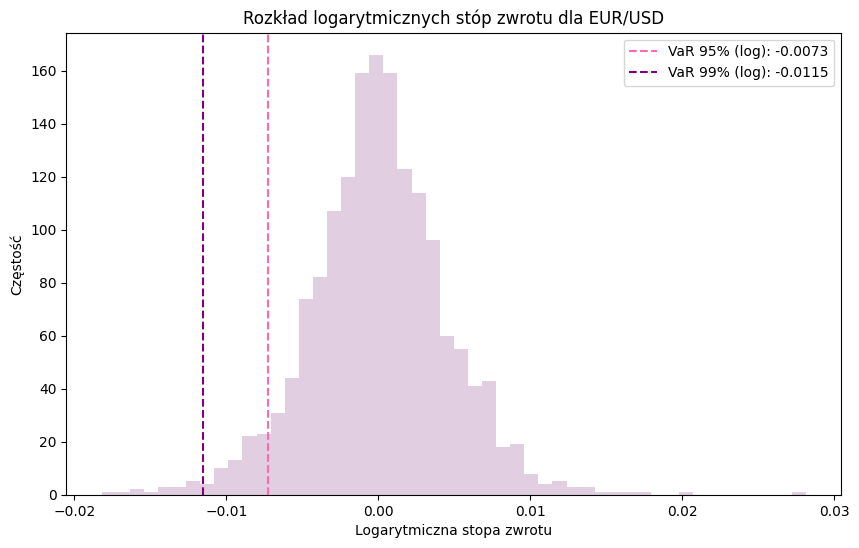

In [16]:
start_date = '2018-01-01'
end_date = '2024-03-31'
jpy = 'USDJPY=X'
eur = 'USDEUR=X'
raw_data = yf.download(tickers=[jpy, eur], start=start_date, end=end_date)["Close"]

raw_data = raw_data.rename(columns={eur: "eur", jpy: "jpy"})

log_returns = np.log(raw_data / raw_data.shift(1))

sorted_log_returns = log_returns.sort_values(by="eur")

# Określamy percentyl dla VaR 95%
VaR_95_log = sorted_log_returns["eur"].quantile(0.05)
VaR_99_log = sorted_log_returns["eur"].quantile(0.01)

print(f"VaR 95% dla EUR/USD (logarytmiczne stopy zwrotu): {VaR_95_log}")

plt.figure(figsize=(10,6))
plt.hist(log_returns['eur'].dropna(), bins=50, alpha=0.75, color="thistle")
plt.axvline(VaR_95_log, color='hotpink', linestyle='--', label=f'VaR 95% (log): {VaR_95_log:.4f}')
plt.axvline(VaR_99_log, color='purple', linestyle='--', label=f'VaR 99% (log): {VaR_99_log:.4f}')
plt.title('Rozkład logarytmicznych stóp zwrotu dla EUR/USD')
plt.xlabel('Logarytmiczna stopa zwrotu')
plt.ylabel('Częstość')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


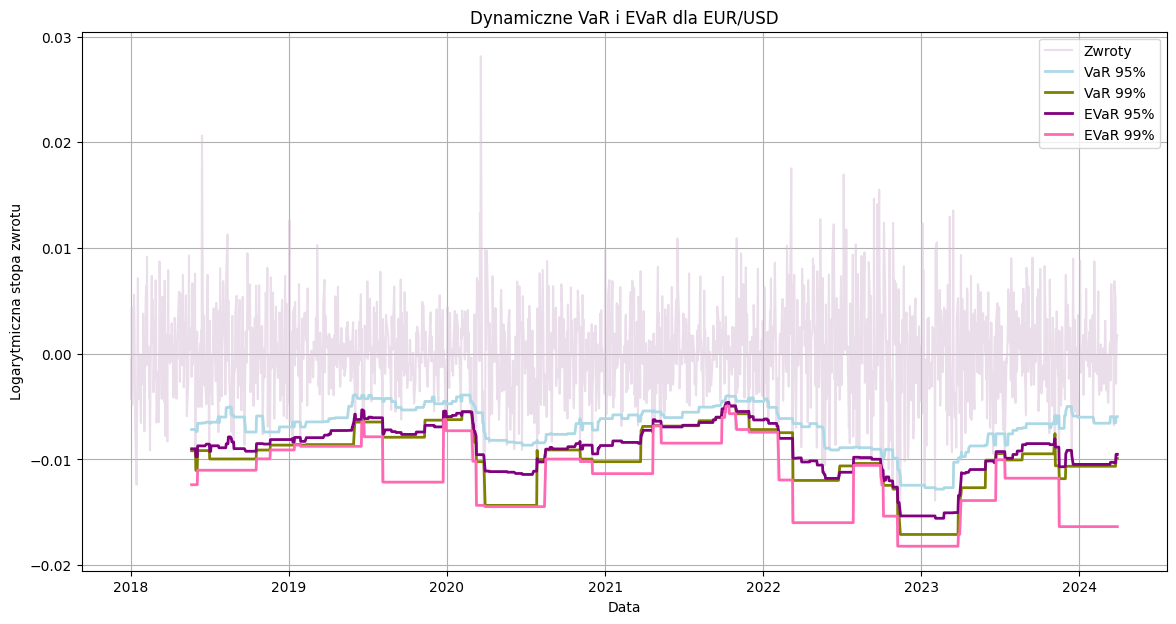

In [15]:

# Parametry
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

# Obliczenie logarytmicznych stóp zwrotu
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

# Parametry okna i poziomy alfa
window = 100
alpha_95 = 0.05
alpha_99 = 0.01

# Funkcja do obliczania Expected Shortfall (EVaR)
def expected_shortfall(returns, alpha):
    var = returns.quantile(alpha)
    es = returns[returns <= var].mean()
    return es

# Przygotowanie serii na wyniki
VaR_95 = pd.Series(index=log_returns.index)
VaR_99 = pd.Series(index=log_returns.index)
EVaR_95 = pd.Series(index=log_returns.index)
EVaR_99 = pd.Series(index=log_returns.index)

# Obliczenia w oknach ruchomych
for i in range(window, len(log_returns)):
    window_data = log_returns.iloc[i-window:i]
    VaR_95.iloc[i] = window_data.quantile(alpha_95)
    VaR_99.iloc[i] = window_data.quantile(alpha_99)
    EVaR_95.iloc[i] = expected_shortfall(window_data, alpha_95)
    EVaR_99.iloc[i] = expected_shortfall(window_data, alpha_99)

# Wykres
plt.figure(figsize=(14,7))
plt.plot(log_returns.index, log_returns, label='Zwroty', color='thistle', alpha=0.5)
plt.plot(VaR_95.index, VaR_95, label='VaR 95%', color='lightblue', linewidth=2)
plt.plot(VaR_99.index, VaR_99, label='VaR 99%', color='olive', linewidth=2)
plt.plot(EVaR_95.index, EVaR_95, label='EVaR 95%', color='purple', linewidth=2)
plt.plot(EVaR_99.index, EVaR_99, label='EVaR 99%', color='hotpink', linewidth=2)
plt.title('Dynamiczne VaR i EVaR dla EUR/USD')
plt.xlabel('Data')
plt.ylabel('Logarytmiczna stopa zwrotu')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


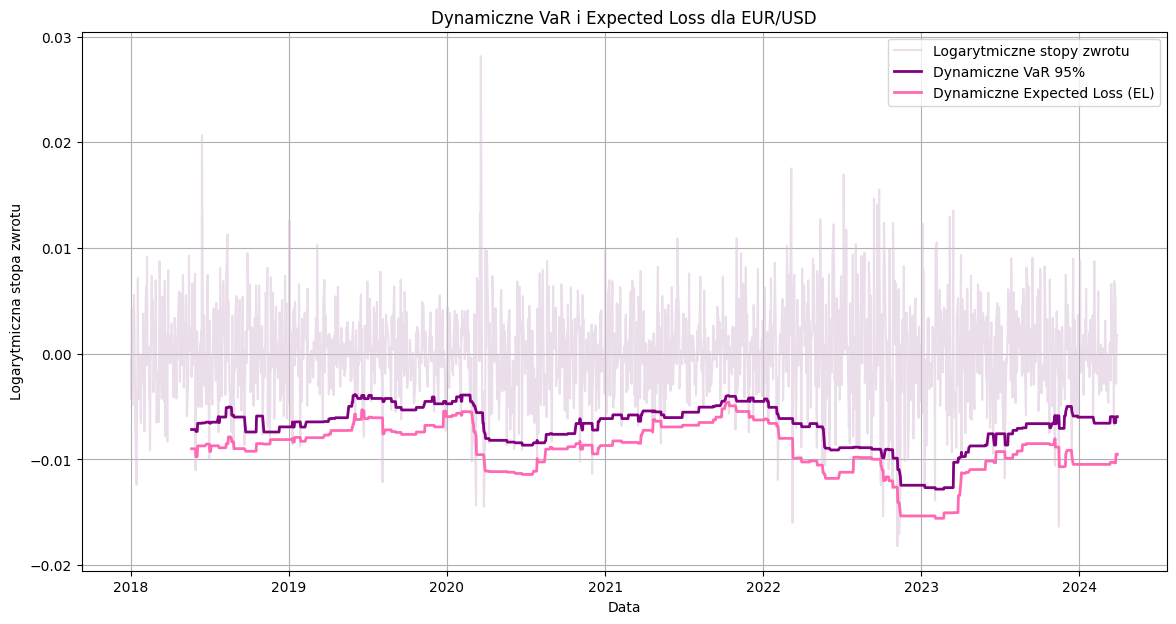

In [19]:
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

# Obliczenie logarytmicznych stóp zwrotu
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

# Parametry okna i alfa
window = 100
alpha_95 = 0.05

# Funkcja do obliczania Expected Loss (EL) — średniej straty poniżej VaR
def expected_loss(returns, var_value):
    return returns[returns <= var_value].mean()

# Przygotowanie serii na wyniki
VaR_95 = pd.Series(index=log_returns.index)
EL_95 = pd.Series(index=log_returns.index)

# Obliczenia dynamiczne w oknach ruchomych
for i in range(window, len(log_returns)):
    window_data = log_returns.iloc[i-window:i]
    VaR_95.iloc[i] = window_data.quantile(alpha_95)
    EL_95.iloc[i] = expected_loss(window_data, VaR_95.iloc[i])

# Wykres
plt.figure(figsize=(14,7))
plt.plot(log_returns.index, log_returns, label='Logarytmiczne stopy zwrotu', color='thistle', alpha=0.5)
plt.plot(VaR_95.index, VaR_95, label='Dynamiczne VaR 95%', color='purple', linewidth=2)
plt.plot(EL_95.index, EL_95, label='Dynamiczne Expected Loss (EL)', color='hotpink', linewidth=2)
plt.title('Dynamiczne VaR i Expected Loss dla EUR/USD')
plt.xlabel('Data')
plt.ylabel('Logarytmiczna stopa zwrotu')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed
C:\Users\zuzia\AppData\Local\Temp\ipykernel_5392\432960340.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(sorted_returns[var_index])


Ważony VaR 95%: -0.0006
Ważony VaR 99%: -0.0006


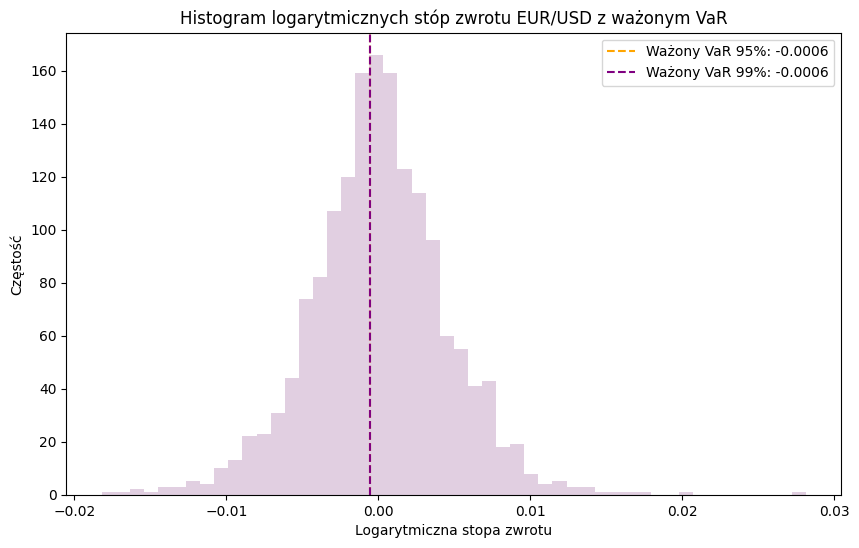

In [26]:


# Parametry
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

# Obliczenie logarytmicznych stóp zwrotu
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

# Parametry do ważenia - lambda do wygaszania wag
_lambda = 0.97
window = 100

# Funkcja do obliczania ważonego VaR
def weighted_var(returns, alpha, lam):
    n = len(returns)
    weights = np.array([lam**(n - i - 1) for i in range(n)])
    weights /= weights.sum()  # normalizacja wag do sumy 1

    # Sortujemy dane wraz z wagami (rosnąco po stopach zwrotu)
    sorted_indices = np.argsort(returns)
    sorted_returns = returns[sorted_indices]
    sorted_weights = weights[sorted_indices]

    # Liczymy skumulowaną sumę wag
    cum_weights = np.cumsum(sorted_weights)

    # Szukamy pierwszego miejsca, gdzie skumulowana waga >= alpha
    var_index = np.searchsorted(cum_weights, alpha)

    # Zapobiegamy wyjściu poza zakres
    if var_index >= len(sorted_returns):
        var_index = len(sorted_returns) - 1

    return float(sorted_returns[var_index])

# Obliczamy ważony VaR 95% i 99% na całym zbiorze (dla całej historii)
VaR_95_weighted = weighted_var(log_returns.values, 0.05, _lambda)
VaR_99_weighted = weighted_var(log_returns.values, 0.01, _lambda)

print(f"Ważony VaR 95%: {VaR_95_weighted:.4f}")
print(f"Ważony VaR 99%: {VaR_99_weighted:.4f}")

# Rysujemy histogram i zaznaczamy VaR
plt.figure(figsize=(10,6))
plt.hist(log_returns, bins=50, alpha=0.75, color='thistle')
plt.axvline(VaR_95_weighted, color='orange', linestyle='--', label=f'Ważony VaR 95%: {VaR_95_weighted:.4f}')
plt.axvline(VaR_99_weighted, color='purple', linestyle='--', label=f'Ważony VaR 99%: {VaR_99_weighted:.4f}')
plt.title('Histogram logarytmicznych stóp zwrotu EUR/USD z ważonym VaR')
plt.xlabel('Logarytmiczna stopa zwrotu')
plt.ylabel('Częstość')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


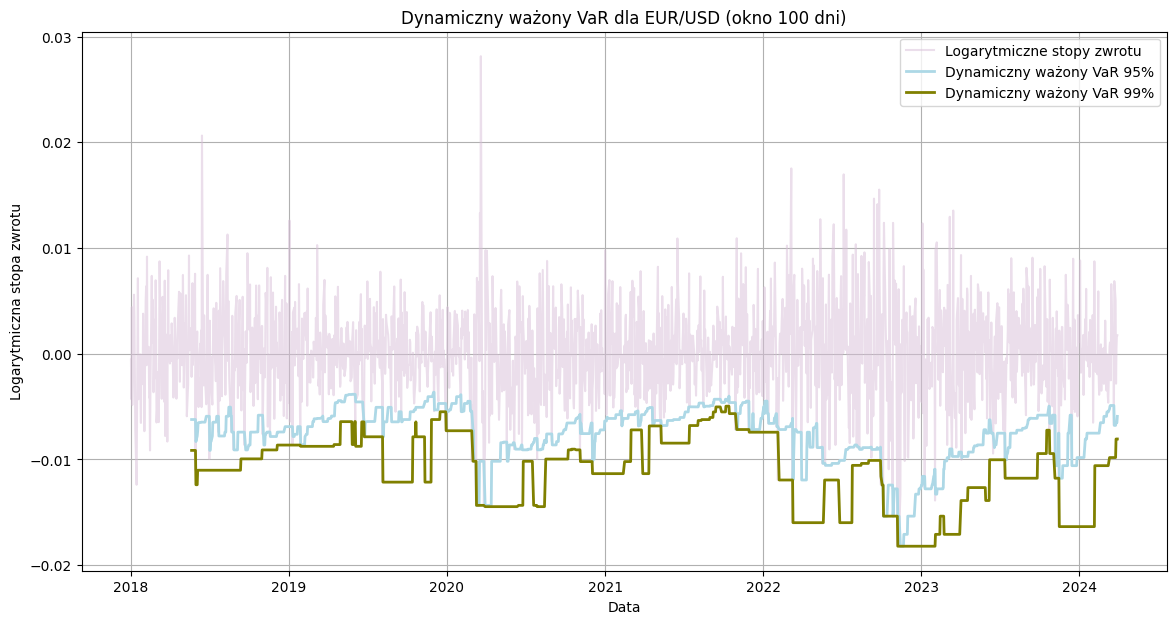

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parametry
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

# Obliczenie logarytmicznych stóp zwrotu (może być DataFrame lub Series)
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

# Jeśli log_returns jest DataFrame, wybieramy pierwszą kolumnę jako Series
if isinstance(log_returns, pd.DataFrame):
    log_returns = log_returns.iloc[:, 0]

# Zamiana na DataFrame z kolumną 'returns'
data = log_returns.to_frame(name='returns')

# Parametry ważenia i okna
_lambda = 0.97
window = 100

# Funkcja ważonego VaR z ważonym quantylem
def weighted_var(losses, alpha, lam=_lambda, statistic='quantile'):
    w1 = 1 / np.sum(lam ** np.arange(len(losses)))
    weights = w1 * lam ** np.arange(len(losses))[::-1]

    if statistic == 'expectile':
        raise NotImplementedError("Expectile not implemented.")
    
    df = pd.DataFrame({'losses': losses, 'weights': weights}).reset_index(drop=True)
    df = df.sort_values(by='losses', ascending=True, ignore_index=True)
    df.weights = df.weights.cumsum()

    idx = df.weights.searchsorted(alpha) - 1
    if idx < 0:
        idx = 0
    
    return df.loc[idx, 'losses']

# Funkcja do obliczania VaR na oknach ruchomych i zapisywania do kolumny
def calculate_var(data, var_func, method_name, alpha=0.05, window=100):
    var_values = []
    for i in range(len(data)):
        if i < window:
            var_values.append(np.nan)
        else:
            window_data = data['returns'].iloc[i-window:i].values
            var = var_func(window_data, alpha)
            var_values.append(var)
    var_col_name = f'var{int((1 - alpha) * 100)}_{method_name}'  # np. var95_ważona dla alpha=0.05
    data[var_col_name] = var_values
    return data

# Obliczanie ważonego VaR 95% i 99%
data = calculate_var(data, weighted_var, 'ważona', alpha=0.05, window=window)
data = calculate_var(data, weighted_var, 'ważona', alpha=0.01, window=window)

# Wykres porównujący zwroty i ważone VaR
plt.figure(figsize=(14,7))
plt.plot(data.index, data['returns'], label='Logarytmiczne stopy zwrotu', color='thistle', alpha=0.5)
plt.plot(data.index, data['var95_ważona'], label='Dynamiczny ważony VaR 95%', color='lightblue', linewidth=2)
plt.plot(data.index, data['var99_ważona'], label='Dynamiczny ważony VaR 99%', color='olive', linewidth=2)
plt.title('Dynamiczny ważony VaR dla EUR/USD')
plt.xlabel('Data')
plt.ylabel('Logarytmiczna stopa zwrotu')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


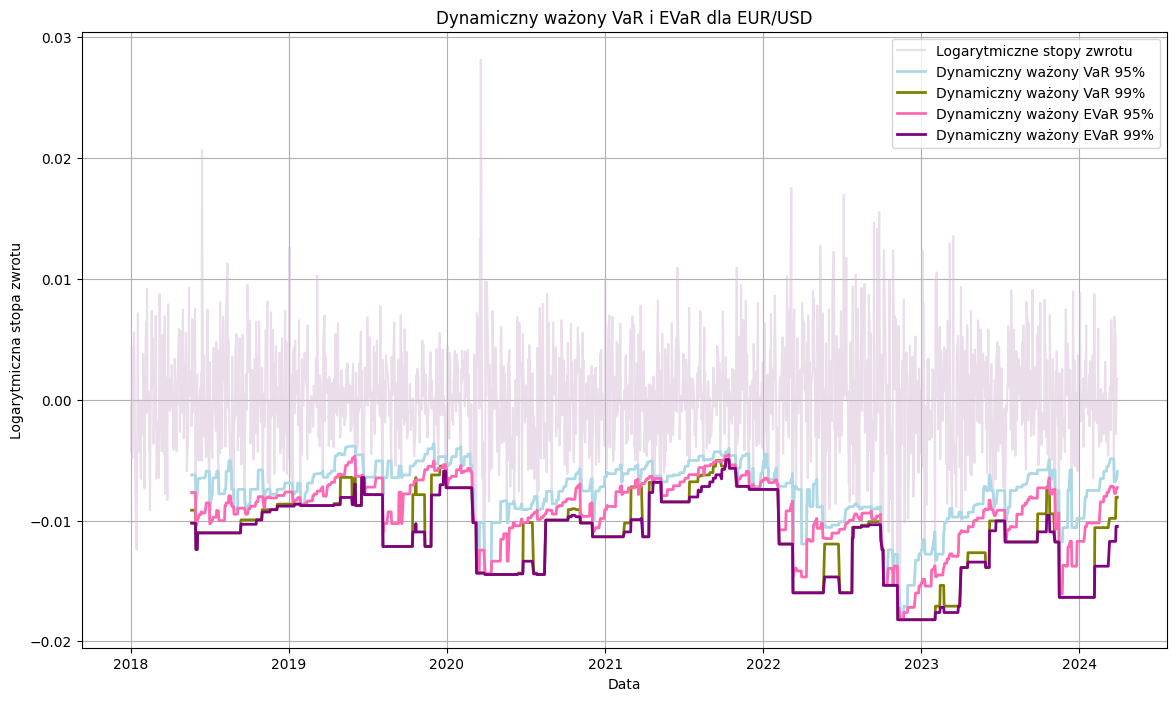

In [35]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parametry
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

# Obliczenie logarytmicznych stóp zwrotu (może być DataFrame lub Series)
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

if isinstance(log_returns, pd.DataFrame):
    log_returns = log_returns.iloc[:, 0]

data = log_returns.to_frame(name='returns')

_lambda = 0.97
window = 100

def weighted_var(losses, alpha, lam=_lambda, statistic='quantile'):
    w1 = 1 / np.sum(lam ** np.arange(len(losses)))
    weights = w1 * lam ** np.arange(len(losses))[::-1]

    if statistic == 'expectile':
        raise NotImplementedError("Expectile not implemented.")
    
    df = pd.DataFrame({'losses': losses, 'weights': weights}).reset_index(drop=True)
    df = df.sort_values(by='losses', ascending=True, ignore_index=True)
    df.weights = df.weights.cumsum()

    idx = df.weights.searchsorted(alpha) - 1
    if idx < 0:
        idx = 0
    
    return df.loc[idx, 'losses']

def expected_shortfall(losses, alpha, lam=_lambda):
    # Liczymy ważony VaR (prog) i potem średnią stratę poniżej tego progu
    var_threshold = weighted_var(losses, alpha, lam)
    weights = lam ** np.arange(len(losses))[::-1]
    weights /= weights.sum()
    df = pd.DataFrame({'losses': losses, 'weights': weights})
    losses_below_var = df[df['losses'] <= var_threshold]
    weights_below_var = losses_below_var['weights']
    losses_values = losses_below_var['losses']
    if len(losses_below_var) == 0:
        return np.nan
    return np.average(losses_values, weights=weights_below_var)

def calculate_var(data, var_func, method_name, alpha=0.05, window=100):
    var_values = []
    for i in range(len(data)):
        if i < window:
            var_values.append(np.nan)
        else:
            window_data = data['returns'].iloc[i-window:i].values
            var = var_func(window_data, alpha)
            var_values.append(var)
    var_col_name = f'var{int((1 - alpha) * 100)}_{method_name}'
    data[var_col_name] = var_values
    return data

def calculate_evar(data, evar_func, method_name, alpha=0.05, window=100):
    evar_values = []
    for i in range(len(data)):
        if i < window:
            evar_values.append(np.nan)
        else:
            window_data = data['returns'].iloc[i-window:i].values
            evar = evar_func(window_data, alpha)
            evar_values.append(evar)
    evar_col_name = f'evar{int((1 - alpha) * 100)}_{method_name}'
    data[evar_col_name] = evar_values
    return data

# Obliczenia VaR i EVaR
data = calculate_var(data, weighted_var, 'ważona', alpha=0.05, window=window)
data = calculate_var(data, weighted_var, 'ważona', alpha=0.01, window=window)
data = calculate_evar(data, expected_shortfall, 'ważona', alpha=0.05, window=window)
data = calculate_evar(data, expected_shortfall, 'ważona', alpha=0.01, window=window)

# Wykres
plt.figure(figsize=(14,8))
plt.plot(data.index, data['returns'], label='Logarytmiczne stopy zwrotu', color='thistle', alpha=0.5)
plt.plot(data.index, data['var95_ważona'], label='Dynamiczny ważony VaR 95%', color='lightblue', linewidth=2)
plt.plot(data.index, data['var99_ważona'], label='Dynamiczny ważony VaR 99%', color='olive', linewidth=2)
plt.plot(data.index, data['evar95_ważona'], label='Dynamiczny ważony EVaR 95%', color='hotpink', linewidth=2)
plt.plot(data.index, data['evar99_ważona'], label='Dynamiczny ważony EVaR 99%', color='purple', linewidth=2)
plt.title('Dynamiczny ważony VaR i EVaR dla EUR/USD')
plt.xlabel('Data')
plt.ylabel('Logarytmiczna stopa zwrotu')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


Ważony VaR 95%: -0.0056
Ważony VaR 99%: -0.0075


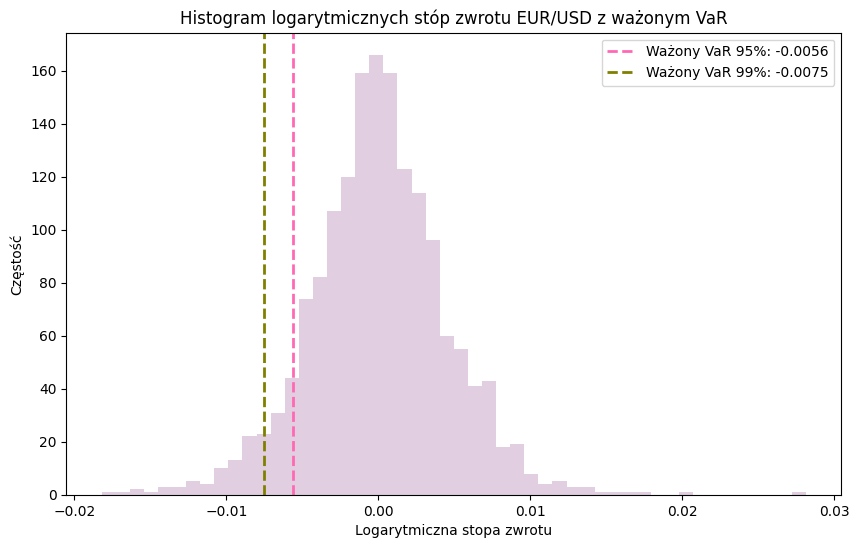

In [38]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parametry
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

# Obliczenie logarytmicznych stóp zwrotu
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

if isinstance(log_returns, pd.DataFrame):
    log_returns = log_returns.iloc[:, 0]

losses = log_returns.values

_lambda = 0.97

def weighted_var(losses, alpha, lam=_lambda):
    w1 = 1 / np.sum(lam ** np.arange(len(losses)))
    weights = w1 * lam ** np.arange(len(losses))[::-1]

    df = pd.DataFrame({'losses': losses, 'weights': weights}).reset_index(drop=True)
    df = df.sort_values(by='losses', ascending=True, ignore_index=True)
    df.weights = df.weights.cumsum()

    idx = df.weights.searchsorted(alpha) - 1
    if idx < 0:
        idx = 0
    
    return df.loc[idx, 'losses']

# Obliczamy globalny ważony VaR 95% i 99%
VaR_95_weighted = weighted_var(losses, 0.05)
VaR_99_weighted = weighted_var(losses, 0.01)

print(f"Ważony VaR 95%: {VaR_95_weighted:.4f}")
print(f"Ważony VaR 99%: {VaR_99_weighted:.4f}")

# Rysujemy histogram i nanosimy linie VaR
plt.figure(figsize=(10,6))
plt.hist(losses, bins=50, alpha=0.75, color='thistle')
plt.axvline(VaR_95_weighted, color='hotpink', linestyle='--', linewidth=2, label=f'Ważony VaR 95%: {VaR_95_weighted:.4f}')
plt.axvline(VaR_99_weighted, color='olive', linestyle='--', linewidth=2, label=f'Ważony VaR 99%: {VaR_99_weighted:.4f}')
plt.title('Histogram logarytmicznych stóp zwrotu EUR/USD z ważonym VaR')
plt.xlabel('Logarytmiczna stopa zwrotu')
plt.ylabel('Częstość')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed


VaR 95% (GARCH): -0.0057
VaR 99% (GARCH): -0.0086


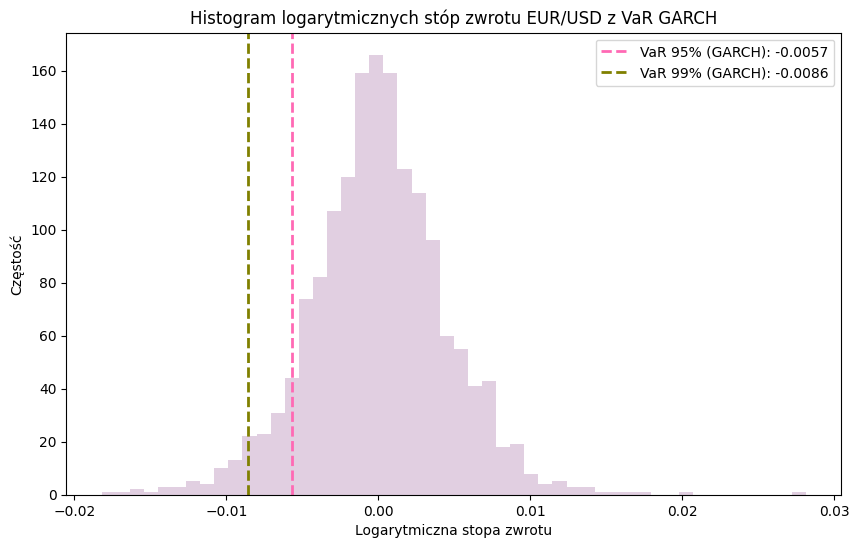

In [45]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Parametry
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

# Logarytmiczne stopy zwrotu
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

if isinstance(log_returns, pd.DataFrame):
    log_returns = log_returns.iloc[:, 0]

def garch_var(losses, alpha, statistic='quantile'):
    losses = losses.dropna() * 100  # na procenty
    model = arch_model(losses, vol="GARCH", p=1, q=1, dist="t", mean='constant')
    res = model.fit(disp='off')
    forecasts = res.forecast(horizon=1)
    variance = forecasts.variance.values[-1, 0]  # wariancja na następny dzień
    mean = forecasts.mean.values[-1, 0]          # średnia na następny dzień

    scaled_losses = (losses - losses.mean()) / res.conditional_volatility
    if statistic == 'quantile':
        q = scaled_losses.quantile(alpha)
        result = (mean + np.sqrt(variance) * q) / 100
        return float(result)  # zwracamy skalara
    else:
        raise NotImplementedError("Only quantile implemented.")

# Liczymy VaR 95% i 99%
VaR_95_garch = garch_var(log_returns, 0.05)
VaR_99_garch = garch_var(log_returns, 0.01)

print(f"VaR 95% (GARCH): {VaR_95_garch:.4f}")
print(f"VaR 99% (GARCH): {VaR_99_garch:.4f}")

# Rysujemy histogram i nanosimy linie VaR
plt.figure(figsize=(10,6))
plt.hist(log_returns, bins=50, alpha=0.75, color='thistle')
plt.axvline(VaR_95_garch, color='hotpink', linestyle='--', linewidth=2, label=f'VaR 95% (GARCH): {VaR_95_garch:.4f}')
plt.axvline(VaR_99_garch, color='olive', linestyle='--', linewidth=2, label=f'VaR 99% (GARCH): {VaR_99_garch:.4f}')
plt.title('Histogram logarytmicznych stóp zwrotu EUR/USD z VaR GARCH')
plt.xlabel('Logarytmiczna stopa zwrotu')
plt.ylabel('Częstość')
plt.legend()
plt.show()


[*********************100%***********************]  1 of 1 completed
c:\Users\zuzia\miniconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\zuzia\miniconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\zu

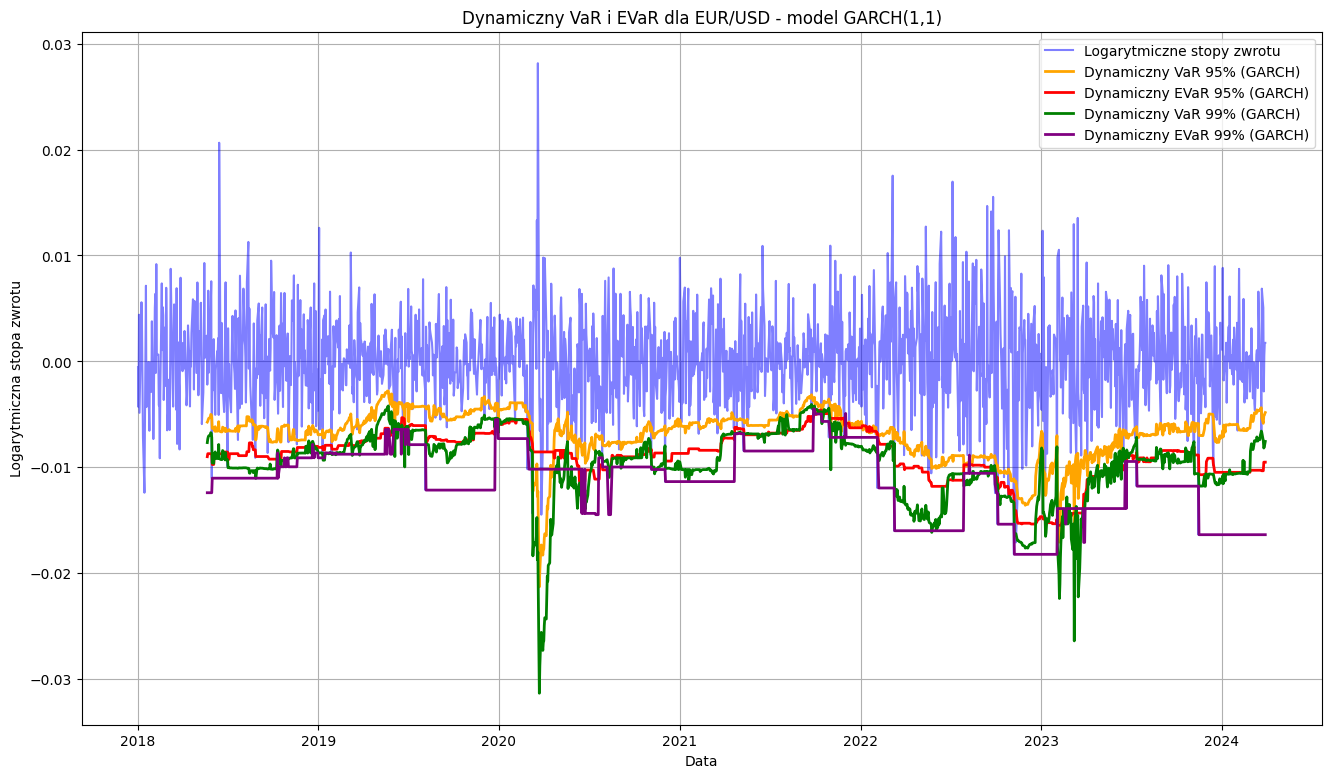

In [46]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Parametry
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'
window = 100  # okno ruchome

# Pobranie danych
raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]

log_returns = np.log(raw_data / raw_data.shift(1)).dropna()
if isinstance(log_returns, pd.DataFrame):
    log_returns = log_returns.iloc[:, 0]

data = log_returns.to_frame(name='returns')

def garch_var_es(window_data, alpha=0.05):
    """
    Oblicza VaR i EVaR na podstawie modelu GARCH(1,1) z rozkładem t dla danych w oknie.
    Zwraca tuple (VaR, EVaR).
    """
    losses = window_data * 100  # przeskalowanie na procenty
    model = arch_model(losses, vol="GARCH", p=1, q=1, dist="t", mean='constant')
    res = model.fit(disp='off')
    forecasts = res.forecast(horizon=1)
    variance = forecasts.variance.values[-1, 0]
    mean = forecasts.mean.values[-1, 0]
    cond_vol = res.conditional_volatility

    # Skaluje losses
    scaled_losses = (losses - losses.mean()) / cond_vol

    # Oblicz quantyl jako VaR
    q = scaled_losses.quantile(alpha)
    VaR = (mean + np.sqrt(variance) * q) / 100  # skalowanie z powrotem

    # Oblicz EVaR jako średnia strat poniżej VaR (ważona przez część rozkładu)
    losses_df = pd.DataFrame({'losses': losses, 'scaled': scaled_losses})
    tail_losses = losses_df[losses_df['scaled'] <= q]
    if len(tail_losses) == 0:
        EVaR = np.nan
    else:
        EVaR = (tail_losses['losses'].mean()) / 100

    return VaR, EVaR

# Przygotowujemy listy wyników
VaR_95_list = []
EVaR_95_list = []
VaR_99_list = []
EVaR_99_list = []

for i in range(len(data)):
    if i < window:
        VaR_95_list.append(np.nan)
        EVaR_95_list.append(np.nan)
        VaR_99_list.append(np.nan)
        EVaR_99_list.append(np.nan)
    else:
        window_data = data['returns'].iloc[i - window:i]
        var95, evar95 = garch_var_es(window_data, alpha=0.05)
        var99, evar99 = garch_var_es(window_data, alpha=0.01)
        VaR_95_list.append(var95)
        EVaR_95_list.append(evar95)
        VaR_99_list.append(var99)
        EVaR_99_list.append(evar99)

# Dodajemy kolumny do DataFrame
data['VaR_95_GARCH'] = VaR_95_list
data['EVaR_95_GARCH'] = EVaR_95_list
data['VaR_99_GARCH'] = VaR_99_list
data['EVaR_99_GARCH'] = EVaR_99_list

# Wykres
plt.figure(figsize=(16,9))
plt.plot(data.index, data['returns'], label='Logarytmiczne stopy zwrotu', color='blue', alpha=0.5)
plt.plot(data.index, data['VaR_95_GARCH'], label='Dynamiczny VaR 95% (GARCH)', color='orange', linewidth=2)
plt.plot(data.index, data['EVaR_95_GARCH'], label='Dynamiczny EVaR 95% (GARCH)', color='red', linewidth=2)
plt.plot(data.index, data['VaR_99_GARCH'], label='Dynamiczny VaR 99% (GARCH)', color='green', linewidth=2)
plt.plot(data.index, data['EVaR_99_GARCH'], label='Dynamiczny EVaR 99% (GARCH)', color='purple', linewidth=2)

plt.title('Dynamiczny VaR i EVaR dla EUR/USD - model GARCH(1,1)')
plt.xlabel('Data')
plt.ylabel('Logarytmiczna stopa zwrotu')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
def calculate_exceptions(returns, VaR_series):
    # 1, gdy strata przekracza VaR, 0 w przeciwnym przypadku
    exceptions = (returns < VaR_series).astype(int)
    return exceptions

from statsmodels.stats.proportion import proportions_ztest

def kupiec_test(exceptions, alpha):
    n_exceptions = exceptions.sum()
    n = len(exceptions)
    stat, p_value = proportions_ztest(n_exceptions, n, alpha)
    return p_value

import numpy as np


def christoffersen_test(exceptions):
    # Liczba obserwacji i przekroczeń
    n = len(exceptions)
    
    # Liczba przejść między stanami (0 -> 0, 0 -> 1, 1 -> 0, 1 -> 1)
    n00 = np.sum((exceptions[:-1] == 0) & (exceptions[1:] == 0))
    n01 = np.sum((exceptions[:-1] == 0) & (exceptions[1:] == 1))
    n10 = np.sum((exceptions[:-1] == 1) & (exceptions[1:] == 0))
    n11 = np.sum((exceptions[:-1] == 1) & (exceptions[1:] == 1))
    
    # Prawdopodobieństwa przejścia
    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    
    # Logarytmowa funkcja wiarygodności (log-likelihood)
    L0 = (n01 + n11) * np.log(pi) + (n00 + n10) * np.log(1 - pi)
    L1 = n00 * np.log(1 - pi01) + n01 * np.log(pi01) + n10 * np.log(1 - pi11) + n11 * np.log(pi11)
    
    # Statystyka testu i p-value
    LR_stat = -2 * (L0 - L1)
    p_value = 1 - stats.chi2.cdf(LR_stat, df=1)
    return p_value


In [40]:
!pip install arch


   ---------------------------------------- 0.0/928.2 kB ? eta -:--:--
   --------------------------------- ------ 786.4/928.2 kB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 928.2/928.2 kB 4.3 MB/s eta 0:00:00


In [53]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

# 1. Pobranie danych
start_date = '2018-01-01'
end_date = '2024-03-31'
eur = 'USDEUR=X'

raw_data = yf.download(tickers=eur, start=start_date, end=end_date)["Close"]
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

if isinstance(log_returns, pd.DataFrame):
    log_returns = log_returns.iloc[:, 0]

data = log_returns.to_frame(name='returns')

# 2. Parametry
window = 100
_lambda = 0.97

# 3. Obliczenie VaR zwykłego (ruchome okno)
data['var95_zwykla'] = data['returns'].rolling(window).quantile(0.05)
data['var99_zwykla'] = data['returns'].rolling(window).quantile(0.01)

# 4. Funkcja ważonego VaR
def weighted_var(losses, alpha, lam=_lambda):
    w1 = 1 / np.sum(lam ** np.arange(len(losses)))
    weights = w1 * lam ** np.arange(len(losses))[::-1]
    df = pd.DataFrame({'losses': losses, 'weights': weights}).reset_index(drop=True)
    df = df.sort_values(by='losses', ascending=True, ignore_index=True)
    df.weights = df.weights.cumsum()
    idx = df.weights.searchsorted(alpha) - 1
    if idx < 0:
        idx = 0
    return df.loc[idx, 'losses']

# 5. Obliczenie ważonego VaR (ruchome okno)
def calculate_var_weighted(data, alpha, window):
    var_values = []
    for i in range(len(data)):
        if i < window:
            var_values.append(np.nan)
        else:
            window_data = data['returns'].iloc[i - window:i].values
            var = weighted_var(window_data, alpha)
            var_values.append(var)
    return var_values

data['var95_ważona'] = calculate_var_weighted(data, 0.05, window)
data['var99_ważona'] = calculate_var_weighted(data, 0.01, window)

# 6. Funkcja do dynamicznego VaR metodą GARCH(1,1)
def garch_var(losses, alpha):
    losses = losses * 100
    model = arch_model(losses, vol="GARCH", p=1, q=1, dist="t", mean='constant')
    res = model.fit(disp='off')
    forecasts = res.forecast(horizon=1)
    variance = forecasts.variance.values[-1, 0]
    mean = forecasts.mean.values[-1, 0]
    scaled_losses = (losses - losses.mean()) / res.conditional_volatility
    q = scaled_losses.quantile(alpha)
    return (mean + np.sqrt(variance) * q) / 100

# 7. Obliczenie dynamicznego VaR GARCH (ruchome okno)
def calculate_var_garch(data, alpha, window):
    var_values = []
    for i in range(len(data)):
        if i < window:
            var_values.append(np.nan)
        else:
            window_data = data['returns'].iloc[i - window:i]
            var = garch_var(window_data, alpha)
            var_values.append(var)
    return var_values

data['VaR_95_GARCH'] = calculate_var_garch(data, 0.05, window)
data['VaR_99_GARCH'] = calculate_var_garch(data, 0.01, window)

# 8. Funkcje do backtestingu

def calculate_exceptions(returns, VaR_series):
    return (returns < VaR_series).astype(int)

def kupiec_test(exceptions, alpha):
    n_exceptions = exceptions.sum()
    n = len(exceptions)
    stat, p_value = proportions_ztest(n_exceptions, n, alpha)
    return p_value

def christoffersen_test(exceptions):
    n = len(exceptions)
    n00 = np.sum((exceptions[:-1] == 0) & (exceptions[1:] == 0))
    n01 = np.sum((exceptions[:-1] == 0) & (exceptions[1:] == 1))
    n10 = np.sum((exceptions[:-1] == 1) & (exceptions[1:] == 0))
    n11 = np.sum((exceptions[:-1] == 1) & (exceptions[1:] == 1))
    pi01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    pi11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    pi = (n01 + n11) / (n00 + n01 + n10 + n11)
    L0 = (n01 + n11) * np.log(pi) + (n00 + n10) * np.log(1 - pi)
    L1 = n00 * np.log(1 - pi01) + n01 * np.log(pi01) + n10 * np.log(1 - pi11) + n11 * np.log(pi11)
    LR_stat = -2 * (L0 - L1)
    p_value = 1 - stats.chi2.cdf(LR_stat, df=1)
    return p_value

def percent_exceptions(exceptions):
    return exceptions.sum() / len(exceptions)

# 9. Testy dla VaR 95%

alpha_95 = 0.05

exceptions_95_zwykla = calculate_exceptions(data['returns'], data['var95_zwykla'])
exceptions_95_wazona = calculate_exceptions(data['returns'], data['var95_ważona'])
exceptions_95_garch = calculate_exceptions(data['returns'], data['VaR_95_GARCH'])

print("===== VaR 95% =====")
print("Test Kupca zwykła:", kupiec_test(exceptions_95_zwykla, alpha_95))
print("Test Kupca ważona:", kupiec_test(exceptions_95_wazona, alpha_95))
print("Test Kupca GARCH:", kupiec_test(exceptions_95_garch, alpha_95))
print("Test Christoffersena zwykła:", christoffersen_test(exceptions_95_zwykla.values))
print("Test Christoffersena ważona:", christoffersen_test(exceptions_95_wazona.values))
print("Test Christoffersena GARCH:", christoffersen_test(exceptions_95_garch.values))
print("Procent przekroczeń zwykła:", percent_exceptions(exceptions_95_zwykla))
print("Procent przekroczeń ważona:", percent_exceptions(exceptions_95_wazona))
print("Procent przekroczeń GARCH:", percent_exceptions(exceptions_95_garch))

# 10. Testy dla VaR 99%

alpha_99 = 0.01

exceptions_99_zwykla = calculate_exceptions(data['returns'], data['var99_zwykla'])
exceptions_99_wazona = calculate_exceptions(data['returns'], data['var99_ważona'])
exceptions_99_garch = calculate_exceptions(data['returns'], data['VaR_99_GARCH'])

print("\n===== VaR 99% =====")
print("Test Kupca zwykła:", kupiec_test(exceptions_99_zwykla, alpha_99))
print("Test Kupca ważona:", kupiec_test(exceptions_99_wazona, alpha_99))
print("Test Kupca GARCH:", kupiec_test(exceptions_99_garch, alpha_99))
print("Test Christoffersena zwykła:", christoffersen_test(exceptions_99_zwykla.values))
print("Test Christoffersena ważona:", christoffersen_test(exceptions_99_wazona.values))
print("Test Christoffersena GARCH:", christoffersen_test(exceptions_99_garch.values))
print("Procent przekroczeń zwykła:", percent_exceptions(exceptions_99_zwykla))
print("Procent przekroczeń ważona:", percent_exceptions(exceptions_99_wazona))
print("Procent przekroczeń GARCH:", percent_exceptions(exceptions_99_garch))


[*********************100%***********************]  1 of 1 completed
c:\Users\zuzia\miniconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\zuzia\miniconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09892. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
c:\Users\zu

===== VaR 95% =====
Test Kupca zwykła: 0.7819174798761092
Test Kupca ważona: 0.44926398527233646
Test Kupca GARCH: 0.770823542921302
Test Christoffersena zwykła: 0.016328992251460228
Test Christoffersena ważona: 0.7923349630274152
Test Christoffersena GARCH: 0.4233904699223149
Procent przekroczeń zwykła: 0.048525798525798525
Procent przekroczeń ważona: 0.04606879606879607
Procent przekroczeń GARCH: 0.051597051597051594

===== VaR 99% =====
Test Kupca zwykła: 0.29987734499349916
Test Kupca ważona: 0.11238045144789467
Test Kupca GARCH: 0.0021320432184881175
Test Christoffersena zwykła: 0.2722821605534571
Test Christoffersena ważona: 0.36497361363438074
Test Christoffersena GARCH: 0.7405228067497807
Procent przekroczeń zwykła: 0.012899262899262898
Procent przekroczeń ważona: 0.014742014742014743
Procent przekroczeń GARCH: 0.020884520884520884


In [63]:
import itertools
from scipy import stats

# Słowniki z kolumnami VaR dla 95% i 99%
S95s = {
    'historyczna': data['var95_zwykla'].dropna(),
    'ważona': data['var95_ważona'].dropna(),
    'garch': data['VaR_95_GARCH'].dropna()
}

S99s = {
    'historyczna': data['var99_zwykla'].dropna(),
    'ważona': data['var99_ważona'].dropna(),
    'garch': data['VaR_99_GARCH'].dropna()
}

print("Porównanie VaR 95% (test t dla średnich):")
for a, b in itertools.combinations(S95s.keys(), 2):
    stat, pvalue = stats.ttest_ind(S95s[a], S95s[b], equal_var=False, nan_policy='omit')
    print(f"{a} vs {b}\n statystyka={stat:.4f}, p-value={pvalue:.5f}\n")

print("Porównanie VaR 99% (test t dla średnich):")
for a, b in itertools.combinations(S99s.keys(), 2):
    stat, pvalue = stats.ttest_ind(S99s[a], S99s[b], equal_var=False, nan_policy='omit')
    print(f"{a} vs {b}\n statystyka={stat:.4f}, p-value={pvalue:.5f}\n")


Porównanie VaR 95% (test t dla średnich):
historyczna vs ważona
 statystyka=8.7477, p-value=0.00000

historyczna vs garch
 statystyka=0.1912, p-value=0.84842

ważona vs garch
 statystyka=-8.1559, p-value=0.00000

Porównanie VaR 99% (test t dla średnich):
historyczna vs ważona
 statystyka=10.1287, p-value=0.00000

historyczna vs garch
 statystyka=-1.7025, p-value=0.08877

ważona vs garch
 statystyka=-11.0992, p-value=0.00000

